In [4]:
import os
import pandas as pd
import numpy as np
import pandas_gbq
import unidecode

In [2]:
from google.cloud import bigquery

In [1]:
from dotenv import load_dotenv
load_dotenv('/Users/daniel/OAN/credentials/contoan/.env')

In [21]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

4.9.0


In [22]:
import cufflinks as cf

In [23]:
init_notebook_mode(connected=True)

In [24]:
cf.go_offline()

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

### ANALYCEMOS CUENTAS

In [51]:
sql = """
   SELECT acc.id as `ID`,
       acc.creation_date as `CREACION`,
       acc.execution_date as `EJECUCION`,
       acc.concept as `CONCEPTO`,
       pr.name as `PROJECTO`,
       int.name as `INTERVENCION`,
       ph.name as `FASE`,
       CASE 
        WHEN acc.type = 'expense'  THEN 'Gasto'
        WHEN acc.type = 'income'  THEN 'Ingreso'
        WHEN acc.type = 'movement'  THEN 'Movimiento'
        ELSE ''
      END AS `TIPO`,
       acc.amount as `CANTIDAD`,
       acc.vat as `IVA`,
       acc.vat_amount as `IVA_CTA`,
       tg.name as `CAJA_BANCO`,
       ac.name as `CATEGORIA`,
       acc.description as `DESCRIPCION`,
       cr.name as `CREADOR`,
       rs.name as `RESPONSABLE`,      
       acc.code as `COTADOR`,
       acc.origin as `ORIGEN`,
       acc.place as `LUGAR`,
       acc.receipt as `FACTURA`
       
      
FROM `oan-nikarit.contoan.accounting` acc
LEFT OUTER JOIN `oan-nikarit.contoan.accounts` ac
ON acc.account_id = ac.id
LEFT OUTER JOIN `oan-nikarit.contoan.accounts` tg
ON acc.target_id = tg.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` pr
ON acc.project = pr.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` int
ON acc.intervention = int.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` ph
ON acc.phase = ph.id
LEFT OUTER JOIN `oan-nikarit.contoan.users` cr
ON acc.creator_user = cr.id
LEFT OUTER JOIN `oan-nikarit.contoan.users` rs
ON acc.user_in_charge = rs.id
""".lower()

# Run a Standard SQL query using the environment's default project
df = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 2255/2255 [00:01<00:00, 1491.61rows/s]


In [34]:
df['projecto'].value_counts()

Nikarit                   1794
Administration_general     180
Pompes d'eau                82
ADSAN                       70
Fassol                      57
Emancipacion                43
Forum Nikki                 17
CPNPF                        6
Évènements                   4
Aguapp                       2
Name: projecto, dtype: int64

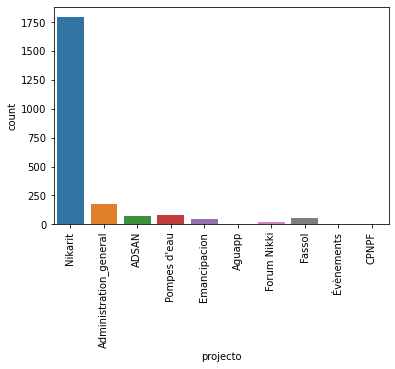

In [36]:
sns.countplot(x='projecto',data=df)
plt.xticks(rotation=90)
plt.show()

In [38]:
df['caja_banco'].value_counts()

Banco Stripe                  1035
Banco Paypal                   365
Banco Caja de Ingenieros       259
Caja Mireille                  168
Banco Santander                137
Caja Kader                      79
Caja Hafiz                      55
Caja Daniel                     37
Caja Abour Rhaman               29
Caja Rasak                      24
Caja Imorou                     14
Caja Habirou                    11
Caja Chemita                     9
Deudas a c.p. (Acreedores)       7
Bank of Africa                   6
Caja                             6
Caja Younous                     5
Deudas a c.p. (Deudores)         4
Caja Sofia                       2
Caja Jaume                       2
Caja Sianson                     1
Name: caja_banco, dtype: int64

In [40]:
df['origen'].value_counts()

script_dani    879
contoan        628
shopify        612
g_forms        136
Name: origen, dtype: int64

In [43]:
df.groupby(['origen','lugar']).count()['id']

origen       lugar
contoan      benin    232
             spain    396
g_forms      benin    135
             spain      1
script_dani  spain    879
shopify      spain    612
Name: id, dtype: int64

In [44]:
print(df.columns)

Index(['id', 'creacion', 'ejecucion', 'concepto', 'projecto', 'invervencion',
       'fase', 'tipo', 'cantidad', 'iva', 'iva_cta', 'caja_banco', 'categoria',
       'descripcion', 'creador', 'responsable', 'cotador', 'origen', 'lugar',
       'factura'],
      dtype='object')


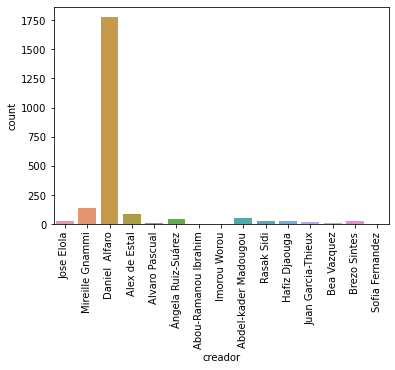

In [45]:
sns.countplot(x='creador',data=df)
plt.xticks(rotation=90)
plt.show()

## NIKARIT

In [54]:
df.columns

Index(['id', 'creacion', 'ejecucion', 'concepto', 'projecto', 'intervencion',
       'fase', 'tipo', 'cantidad', 'iva', 'iva_cta', 'caja_banco', 'categoria',
       'descripcion', 'creador', 'responsable', 'cotador', 'origen', 'lugar',
       'factura'],
      dtype='object')

In [56]:
df_nikarit = df[df['projecto']=='Nikarit']

In [58]:
df_nik_cat=df_nikarit.groupby(['categoria','tipo','intervencion'])['cantidad'].sum().reset_index()

In [59]:
df_nik_cat.head(2)

,categoria,tipo,intervencion,cantidad
0,Alquileres (oficinas y otros),gasto,Espagne General 2020,199.65
1,Apertura,movimiento,Espagne General 2020,12102.71


In [63]:
expense = df_nik_cat[df_nik_cat['tipo']=='gasto']

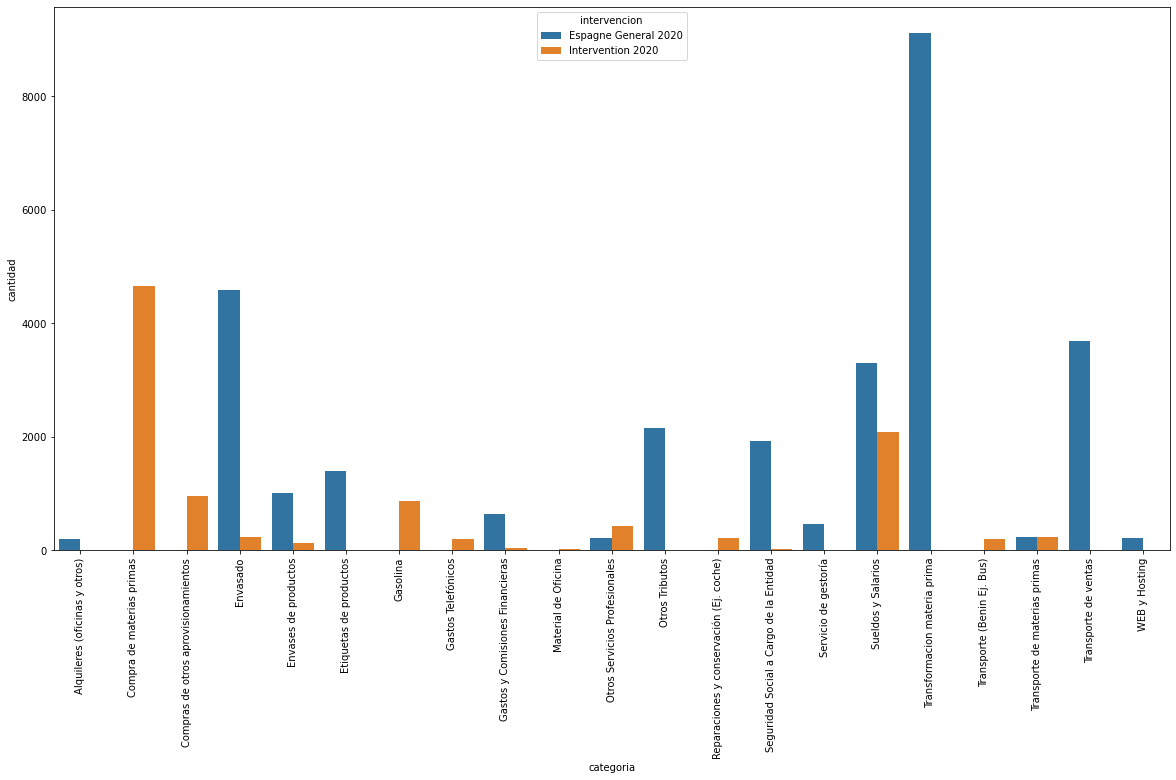

In [64]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x="categoria", y="cantidad",hue='intervencion', data=expense)
plt.xticks(rotation=90)
plt.show()

## INGRESOS Y GASTOS

In [65]:
df_3 = df_nikarit.groupby('tipo')['cantidad'].sum().reset_index()
df_3.head()

,tipo,cantidad
0,gasto,42714.05
1,ingreso,36505.98
2,movimiento,43749.73


In [67]:
df_3.iplot(kind='bar',x='tipo',y='cantidad')

## GASTOS

In [68]:
expense.intervencion.unique()

array(['Espagne General 2020', 'Intervention 2020'], dtype=object)

### NIKKI

In [69]:
expense[expense['intervencion']=='Intervention 2020'
       ]['cantidad'].sum()

10317.959999999997

In [70]:
expense[expense['intervencion']=='Intervention 2020'
       ].sort_values('cantidad',ascending=False)[['categoria','cantidad']]

,categoria,cantidad
7,Compra de materias primas,4663.38
32,Sueldos y Salarios,2089.25
8,Compras de otros aprovisionamientos,965.13
17,Gasolina,866.21
25,Otros Servicios Profesionales,425.28
37,Transporte de materias primas,230.19
13,Envasado,228.66
27,Reparaciones y conservación (Ej. coche),223.32
19,Gastos Telefónicos,201.03
35,Transporte (Benin Ej. Bus),195.22


In [71]:
expense[expense['intervencion']=='Intervention 2020'
       ].sort_values('cantidad',ascending=False
                    ).iplot(kind='bar',x='categoria',
                            y='cantidad',title='GASTOS NIKKI - 3853.75 €')

In [94]:
df_nikarit[(df_nikarit['intervencion']=='Intervention 2020') &
         (df_nikarit['categoria']=='Sueldos y Salarios')
          ][['concepto','cantidad','descripcion','creacion']].sort_values('creacion')


,concepto,cantidad,descripcion,creacion
578,Salaire / Personnelle,22.83,"Salaire de Younous, Mireille et Lamatou pour l...",2020-02-27 10:24:26+00:00
579,Salaire / Personnelle,175.05,"Salarios acumulados de Younous, Lamatou y Mire...",2020-03-11 12:36:58+00:00
580,Salaire / Personnelle,60.89,Salaires del mes de febrero 2020 de Younous y ...,2020-03-11 13:04:54+00:00
575,Salaire / Personnelle,45.66,"2 visites aux villages nouveaux avec Lamatou, ...",2020-03-17 23:19:42+00:00
577,Salaire / Personnelle,91.33,Salaire pour voyage dans les villages,2020-04-02 12:17:30+00:00
576,Salaire / Personnelle,91.33,Salaire mensuel,2020-05-03 16:15:07+00:00
574,Salaire / Personnelle,53.35,Salaire younouss et lamatou,2020-05-03 16:20:03+00:00
553,entretien younouss,22.87,entretien de younouss pour voyager dans les vi...,2020-06-19 06:54:26.105000+00:00
495,salaire younouss,60.98,entretien de younouss du voyage sur parakou po...,2020-06-19 07:36:31.176000+00:00
552,salaire mireille,121.95,salaire du mois de Mai,2020-06-19 07:52:09.020000+00:00


Salaire / Personnelle	91.33	04-30	Salaire mensuel (ABRIL)
salaire mireille	121.95	06-01	salaire du mois de Mai
alaire mireille	182.93	07-10	salaire du mois de juin
salaire mireille	182.93	07-31	salaire du mois de juillet
Salaire / Personnelle	175.05	12-23	Salarios acumulados de Younous, Lamatou y Mire...


## ESPAÑA

In [60]:
expense[expense['inter']=='Espagne General 2020'].sort_values('amount',ascending=False)[['categoria','amount']]

,categoria,amount
30,Transformacion materia prima,7476.64
34,Transporte de ventas,3631.65
28,Sueldos y Salarios,3296.18
23,Otros Tributos,2149.46
25,Seguridad Social a Cargo de la Entidad,1930.91
14,Etiquetas de productos,1129.81
13,Envases de productos,1003.24
27,Servicio de gestoría,467.95
18,Gastos y Comisiones Financieras,391.27
36,WEB y Hosting,210.25


In [96]:
expense[expense['intervencion']=='Espagne General 2020']['cantidad'].sum()

29177.75

In [98]:
expense[expense['intervencion']=='Espagne General 2020'
       ].sort_values('cantidad',ascending=False
                    ).iplot(kind='bar',x='categoria',y='cantidad',title='Gastos Totales 21,909€'
                           )

In [99]:
df_nik_cat.categoria.unique()

array(['Alquileres (oficinas y otros)', 'Apertura',
       'Banco Caja de Ingenieros', 'Banco Paypal', 'Banco Santander',
       'Banco Stripe', 'Caja', 'Compra de materias primas',
       'Compras de otros aprovisionamientos',
       'Deudas a c.p. (Acreedores)', 'Deudas gastos de envio',
       'Donaciones', 'Envasado', 'Envases de productos',
       'Etiquetas de productos', 'Gasolina', 'Gastos Telefónicos',
       'Gastos y Comisiones Financieras', 'Material de Oficina',
       'Otros Servicios Profesionales', 'Otros Tributos',
       'Reparaciones y conservación (Ej. coche)',
       'Seguridad Social a Cargo de la Entidad', 'Servicio de gestoría',
       'Sueldos y Salarios', 'Transformacion materia prima',
       'Transporte (Benin Ej. Bus)', 'Transporte de materias primas',
       'Transporte de ventas', 'Venta de Manteca de Karite',
       'WEB y Hosting'], dtype=object)

### ANALIZAR COMISIONES

In [102]:
df2=df_nikarit[(df_nikarit['intervencion']=='Espagne General 2020')&
                (df_nikarit['origen'] !='contoan' )].groupby('categoria')['cantidad'].sum().reset_index()

In [103]:
#Ingresos shopify
df2[df2['categoria']=='Venta de Manteca de Karite']['cantidad'].values[0]

19751.980000000014

In [104]:
#Comisiones pagos en shopify
df2[df2['categoria']=='Gastos y Comisiones Financieras']['cantidad'].values[0]

590.91

In [105]:
#Ratio de comision
100*(df2[df2['categoria']=='Gastos y Comisiones Financieras']['cantidad'].values[0]
 /df2[df2['categoria']=='Venta de Manteca de Karite']['cantidad'].values[0])

2.9916494447645223

In [106]:
df_nikarit['categoria'].unique()

array(['Gastos y Comisiones Financieras', 'Deudas gastos de envio',
       'Donaciones', 'Venta de Manteca de Karite',
       'Transporte (Benin Ej. Bus)', 'Compra de materias primas',
       'Gasolina', 'Reparaciones y conservación (Ej. coche)',
       'Transporte de materias primas',
       'Compras de otros aprovisionamientos', 'Sueldos y Salarios',
       'Seguridad Social a Cargo de la Entidad', 'Material de Oficina',
       'Gastos Telefónicos', 'Otros Servicios Profesionales',
       'Envases de productos', 'Envasado', 'Transformacion materia prima',
       'Caja', 'Banco Santander', None, 'Transporte de ventas',
       'Etiquetas de productos', 'Banco Stripe',
       'Deudas a c.p. (Acreedores)', 'WEB y Hosting',
       'Banco Caja de Ingenieros', 'Servicio de gestoría', 'Banco Paypal',
       'Otros Tributos', 'Apertura', 'Alquileres (oficinas y otros)'],
      dtype=object)

In [108]:
df_nikarit[(df_nikarit['intervencion']=='Intervention 2020') &
         (df_nikarit['categoria']=='Compras de otros aprovisionamientos')
          ][['concepto','cantidad','creacion','descripcion']].sort_values('creacion')

,concepto,cantidad,creacion,descripcion
573,Achat de materiaux,45.66,2020-02-26 22:58:25+00:00,Achat d'une bascul de maximum 100 kilos pour p...
570,Achat de materiaux,45.66,2020-02-26 23:06:58+00:00,Achat piece pour reparation moulin Bessen Gourou
596,Achat de materiaux,24.35,2020-02-29 15:48:56+00:00,Achat de 10 metres de tissus a 6.000 F le tota...
568,Carte d'identité,4.57,2020-03-11 12:59:18+00:00,Carte d'identité
594,Achat de materiaux,38.97,2020-03-11 20:32:07+00:00,Compra de 12 metros de tela en el mercado a 72...
595,Achat de materiaux,49.47,2020-03-12 14:49:57+00:00,Compra de 56 metros de tela para el pedido de ...
571,Achat de materiaux,96.12,2020-03-17 23:24:14+00:00,Couture 421 petits sacs chez Kasim
572,Achat de materiaux,27.40,2020-05-04 08:43:15+00:00,Achat de pneu
509,achat matériels des femmes,334.15,2020-06-27 08:24:40.552000+00:00,achat des sacs pour emballer les amandes de ka...
489,achats de gants,68.60,2020-08-10 11:16:16.321000+00:00,achats de gants pour les femmes de monnon


## ventas

In [229]:
sql = """
    SELECT *
    FROM `oan-nikarit.contoan.sales`
"""

# Run a Standard SQL query using the environment's default project
df_ventas = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 846/846 [00:01<00:00, 477.47rows/s]


In [230]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   id                       846 non-null    object             
 1   client_gender            846 non-null    object             
 2   product_movement         203 non-null    object             
 3   buyer_accepts_marketing  216 non-null    object             
 4   balsamo_unit_price       846 non-null    float64            
 5   total_tax                846 non-null    float64            
 6   crema_nb                 846 non-null    int64              
 7   manteca_unit_price       846 non-null    float64            
 8   close_date               697 non-null    datetime64[ns, UTC]
 9   packContigo_nb           846 non-null    int64              
 10  subtotal_price           846 non-null    float64            
 11  packHidra_nb             846 non

In [231]:
df_ventas=df_ventas.sort_values('creation_date',
                                ascending=True).reset_index(drop=True)

In [232]:
(100*df_ventas['province'].value_counts()/537)[0:10]

Madrid        79.515829
Barcelona      8.379888
Valladolid     7.821229
Valencia       5.586592
Málaga         4.096834
A Coruña       3.165736
Cantabria      2.979516
Asturias       2.793296
Granada        2.607076
Sevilla        2.234637
Name: province, dtype: float64

In [180]:
df_ventas_shopi = df_ventas[df_ventas['origin']=='Shopify'].reset_index(drop=True)

In [182]:
shop_url = os.environ['SHOPIFY_ACCESS_URL']
dates = ['2019-01-01T00:15:47-04:00','2020-01-01T00:15:47-04:00',
         '2020-05-01T00:15:47-04:00','2020-12-10T00:15:47-04:00', '2021-01-10T00:15:47-04:00']
l_orders = []

for date_min,date_max in zip(dates[:-1],dates[1:]):
    orders_url = shop_url+'/orders.json'
    r = requests.get(orders_url,
                 params={
                        'limit':250,
                        'status':'any',
                         'created_at_max':date_max,
                         'created_at_min':date_min
                        })
    orders = pd.DataFrame(r.json()['orders'])
    l_orders.append(orders)
df_orders = pd.concat(l_orders,axis=0).reset_index().drop_duplicates(subset=['id'])

In [183]:
df_ord = df_orders

In [186]:
df_ord['ship_province'] = df_ord['shipping_address'].apply(lambda x: x['province'])

In [197]:
df_ord['ship_latitude'] = df_ord['shipping_address'].apply(lambda x: x['latitude'])
df_ord['ship_longitude'] = df_ord['shipping_address'].apply(lambda x: x['longitude'])


In [187]:
(100*df_ord['ship_province'].value_counts()/len(df_ord['ship_province'])).apply(lambda x: str(round(x,2))+'%')[0:10]

Madrid        51.05%
Barcelona      5.66%
Valladolid     5.41%
Valencia       3.81%
Málaga         2.83%
Cantabria      2.09%
Asturias       2.09%
A Coruña       2.09%
Granada         1.6%
Murcia          1.6%
Name: ship_province, dtype: object

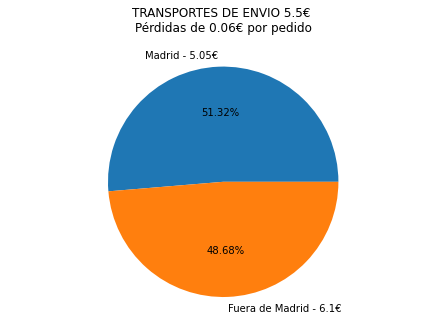

In [188]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Madrid - 5.05€', 'Fuera de Madrid - 6.1€']
students = [51.32,100-51.32]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= 'TRANSPORTES DE ENVIO 5.5€ \nPérdidas de {}€ por pedido'.format(abs(round(0.5132*(5.5-5.05)+(1-0.5132)*(5.5-6.1),2)))
plt.title(title)
plt.show()

In [189]:
counts=df_ord['email'].replace('',np.nan).dropna().value_counts().reset_index()
counts.columns=['email','counts']

In [190]:
email_counts = pd.merge(counts.reset_index(),
         df_ord[['email','ship_province']],
         on='email',how='left').drop('index',axis=1).drop_duplicates('email')

In [192]:
counts_total = email_counts['counts'].value_counts().sort_values(ascending=False)
counts_perc = (100*email_counts[
                                'counts'
                              ].value_counts().sort_values(
                                                            ascending=False
                                                         )
                               /len(email_counts['counts'])
              ).apply(lambda x:str(round(x,2))+'%')
                      
labels=['un solo pedido','dos pedidos','tres pedidos','cuatro pedidos','cinco pedidos']
pd.DataFrame({'Numero de Pedidos x Cliente':labels,'Nº de Clientes':counts_total,'% total':counts_perc})

,Numero de Pedidos x Cliente,Nº de Clientes,% total
1,un solo pedido,593,88.11%
2,dos pedidos,54,8.02%
3,tres pedidos,17,2.53%
4,cuatro pedidos,7,1.04%
7,cinco pedidos,2,0.3%


Text(0, 0.5, 'counts')

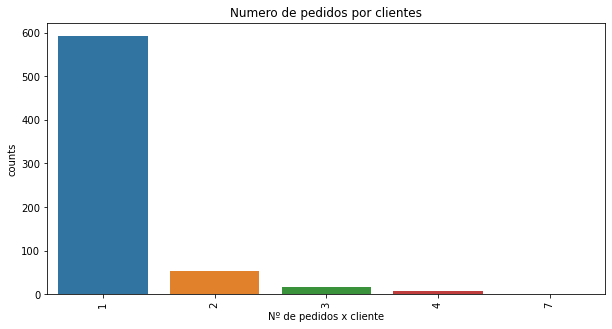

In [193]:
fig = plt.figure(figsize=(10,5))
sns.countplot('counts',data=email_counts.sort_values('counts'))
plt.xticks(rotation=90)
plt.title('Numero de pedidos por clientes')
plt.xlabel('Nº de pedidos x cliente')
plt.ylabel('counts')

### con latitud longitud

In [198]:
df_ord.apply(lambda x: str(x['ship_latitude'])+str(x['ship_longitude']),axis=1
            ).replace('nannan',np.nan).dropna().value_counts().value_counts()


1    620
2     41
3      8
4      2
8      1
dtype: int64

## en cuantas nos comemos el transporte

In [199]:
df_ventas.columns

Index(['client_last_name', 'country', 'creation_date', 'manteca_nb',
       'close_date', 'order_id', 'crema_nb', 'crema_total_price',
       'accounting_item', 'latitude', 'balsamo_total_price', 'balsamo_nb',
       'total_price', 'packHidra_total_price', 'client_gender',
       'subtotal_price', 'balsamo_unit_price', 'packHidra_nb',
       'product_movement', 'origin', 'total_tax', 'client_name',
       'packHidra_unit_price', 'packContigo_total_price', 'order_status_url',
       'longitude', 'packContigo_unit_price', 'manteca_total_price',
       'manteca_unit_price', 'zip', 'client_email', 'province',
       'packContigo_nb', 'crema_unit_price', 'gateway', 'id',
       'packBandana_total_price', 'packAbanico_unit_price', 'bolsa_nb',
       'packBandana_unit_price', 'client_phone', 'bolsa_total_price',
       'client_adresse', 'city', 'packAbanico_nb', 'packNavidad_unit_price',
       'bolsa_unit_price', 'packNavidad_nb', 'packNavidad_total_price',
       'packAbanico_total_price', 

54.0
44.0


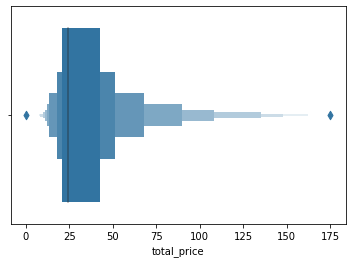

In [200]:
thres = df_ventas['total_price'].quantile(0.99)
sns.boxenplot(x=df_ventas[df_ventas['total_price']<thres]['total_price'])
print(df_ventas['total_price'].quantile(0.90))
print(df_ventas['total_price'].quantile(0.75))
plt.show()

Text(0.5, 1.0, 'Histograma de precios/ingresos de los pedidos\n (sin right_outliers)')

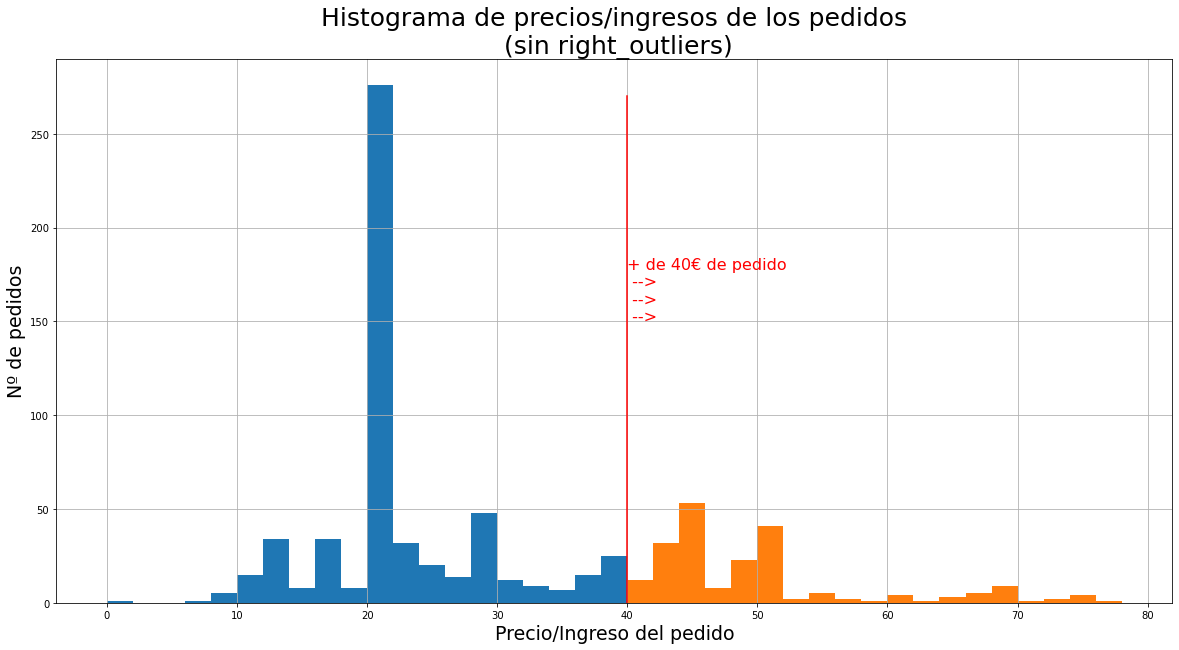

In [201]:
thres = df_ventas['total_price'].quantile(0.98)
#total_price=df_ventas[df_ventas['total_price']<thres]['total_price']
df_ventas[df_ventas['total_price']<40]['total_price'].hist(bins=np.arange(0,41,2),figsize=(20,10))
df_ventas[df_ventas['total_price']>40]['total_price'].hist(bins=np.arange(40,80,2),figsize=(20,10))
plt.xlabel('Precio/Ingreso del pedido',fontsize=19)
plt.ylabel('Nº de pedidos',fontsize=19)
plt.plot(40*np.ones(10),30*np.arange(10),color='r')
plt.text(40,150,'+ de 40€ de pedido\n -->\n -->\n -->',fontsize=16,color='r')
plt.title('Histograma de precios/ingresos de los pedidos\n (sin right_outliers)',fontsize=25)

In [207]:
thres=40
len(df_ventas)
menores = round(len(df_ventas[df_ventas['total_price']<thres]['total_price'])/len(df_ventas),2)
menores

0.67

In [208]:
mayores = round(len(df_ventas[df_ventas['total_price']>=thres]['total_price'])/len(df_ventas),2)
mayores

0.33

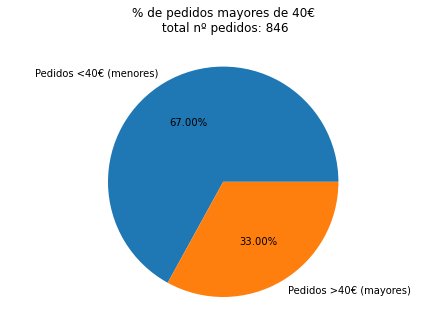

In [210]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Pedidos <40€ (menores)', 'Pedidos >40€ (mayores)']
students = [menores,mayores]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= '% de pedidos mayores de 40€\n total nº pedidos: {}'.format(len(df_ventas))
plt.title(title)
plt.show()

In [213]:
ventas_cols = df_ventas.columns

In [215]:
nb = [col for col in ventas_cols if 'nb' in col]

In [223]:
df_ventas.fillna(0.0,inplace=True)

In [225]:
df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC||'
                 )+(str(x['packNavidad_nb'])+'_packN'
                 )
                 ),axis=1
               ).value_counts()[0:20]

0_cre||0_bal||0_mant||1_packH||0_packC||0.0_packN    300
0_cre||0_bal||0_mant||0_packH||0_packC||2.0_packN     51
0_cre||0_bal||1_mant||0_packH||0_packC||0.0_packN     51
0_cre||0_bal||0_mant||3_packH||0_packC||0.0_packN     42
0_cre||0_bal||0_mant||0_packH||0_packC||1.0_packN     37
0_cre||0_bal||0_mant||2_packH||0_packC||0.0_packN     37
0_cre||0_bal||2_mant||0_packH||0_packC||0.0_packN     23
0_cre||0_bal||1_mant||2_packH||0_packC||0.0_packN     18
0_cre||0_bal||3_mant||0_packH||0_packC||0.0_packN     15
0_cre||0_bal||1_mant||1_packH||0_packC||0.0_packN     13
0_cre||0_bal||0_mant||4_packH||0_packC||0.0_packN     11
0_cre||0_bal||6_mant||0_packH||0_packC||0.0_packN     11
0_cre||0_bal||0_mant||0_packH||0_packC||4.0_packN     10
0_cre||0_bal||5_mant||0_packH||0_packC||0.0_packN     10
0_cre||0_bal||0_mant||0_packH||0_packC||3.0_packN      8
0_cre||1_bal||2_mant||0_packH||0_packC||0.0_packN      8
1_cre||0_bal||0_mant||2_packH||0_packC||0.0_packN      7
0_cre||1_bal||1_mant||0_packH||

In [228]:
df_ventas['subtotal_price']

0      <function iva at 0x7f9c19b2c4c0>
1      <function iva at 0x7f9c19b2c4c0>
2      <function iva at 0x7f9c19b2c4c0>
3      <function iva at 0x7f9c19b2c4c0>
4      <function iva at 0x7f9c19b2c4c0>
                     ...               
841    <function iva at 0x7f9c19b2c4c0>
842    <function iva at 0x7f9c19b2c4c0>
843    <function iva at 0x7f9c19b2c4c0>
844    <function iva at 0x7f9c19b2c4c0>
845    <function iva at 0x7f9c19b2c4c0>
Name: subtotal_price, Length: 846, dtype: object

Text(0, 0.5, 'precios')

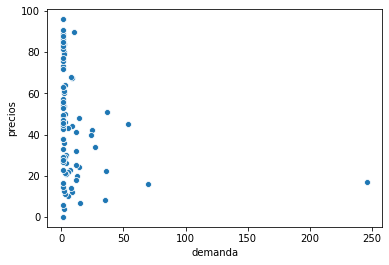

In [233]:
#precios y demanda gráficos
demand_plot = df_ventas[df_ventas['subtotal_price']<100]['subtotal_price'].value_counts().reset_index()
sns.scatterplot(x='subtotal_price',y='index',data=demand_plot)
plt.xlabel('demanda')
plt.ylabel('precios')

## HOW MUCH MONEY DO WE LOOSE

In [234]:
thres = df_ventas['subtotal_price'].quantile(0.97)
print(thres)
total_price=df_ventas[df_ventas['subtotal_price']<thres]['subtotal_price']
print(len(total_price))
total_revenue=total_price.sum()
total_revenue

90.0
811


22545.8

In [235]:
thres=40
lost_transport=5.56*0.25*len(total_price)
lost_transport

1127.29

Text(0, 0.5, '€')

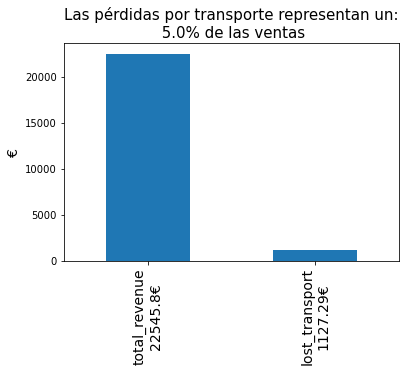

In [236]:
labels=['total_revenue\n{}€'.format(round(total_revenue,2)),
        'lost_transport\n{}€'.format(round(lost_transport,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_revenue,lost_transport]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por transporte representan un:\n {}% de las ventas'.format(
                            round(100*(lost_transport/total_revenue),2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

### comisiones financieras

In [237]:
def comisiones(x):
    gateway = x['gateway']
    if gateway== 'shopify_payments':
        return x['total_price']*0.021+0.25
    elif gateway== 'paypal':
        return x['total_price']*0.019+0.35
    else:
        print('error')
        print(gateway)
    return 0

In [238]:
#comisiones
df_ventas_shop = df_ventas[
                           #(df_ventas['origin'] != 'Contoan') &
                           #(df_ventas['gateway'] != 'shopify_payments')]
                           #(df_ventas['gateway'] != 'paypal')]
                          (df_ventas['origin'] != 'Contoan')]
total_comisiones=df_ventas_shop.apply(lambda x: comisiones(x),axis=1).sum()
total_comisiones

814.9623300000001

In [239]:
total_sin_trans = df_ventas_shop['subtotal_price'].sum()
total_sin_trans

26214.3

In [240]:
100*total_comisiones/total_sin_trans

3.1088464311463593

Text(0, 0.5, '€')

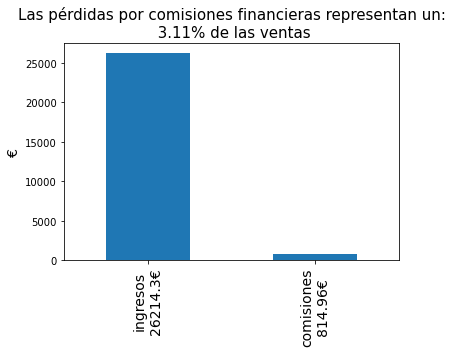

In [241]:
labels=['ingresos\n{}€'.format(round(total_sin_trans,2)),
        'comisiones\n{}€'.format(round(total_comisiones,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_sin_trans,total_comisiones]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por comisiones financieras representan un:\n {}% de las ventas'.format(
                            round(100*total_comisiones/total_sin_trans,2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

Etiquetas (x2)		0.13 €
Envase+envasado+materia prima		1.16 €
Cajas		0.32 €

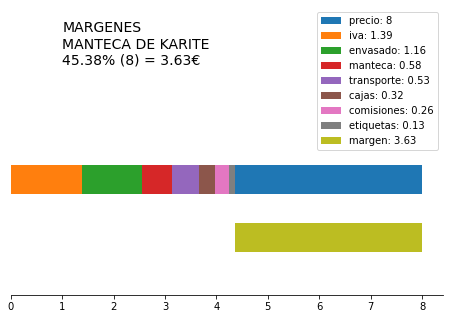

In [242]:
#MANTECAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=8
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.16
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))


#COSTE MANTECA
manteca=0.58
left=left+envasado
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+manteca
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.13
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#margen
left=left+etiquetas
margen=precio-left
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack1=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nMANTECA DE KARITE\n{}% (8) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

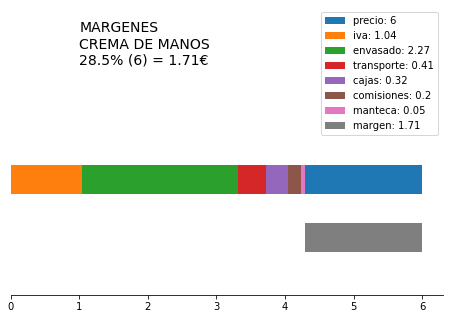

In [243]:
#CREMAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=6
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=2.27
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env2=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#COSTE MANTECA
manteca=0.05
left=left+comisiones
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack2=envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nCREMA DE MANOS\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

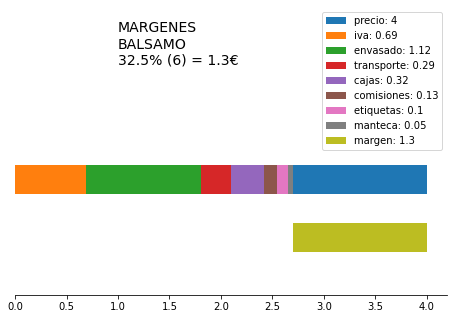

In [245]:
#BALSAMOS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=4
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.12
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env3=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.1
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#COSTE MANTECA
manteca=0.05
left=left+etiquetas
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nBALSAMO\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

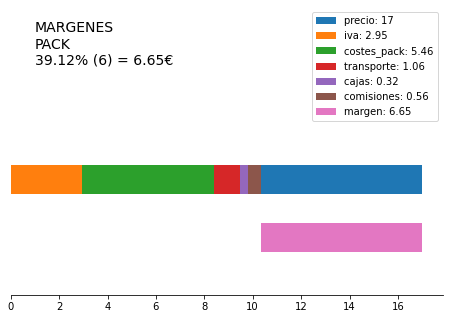

In [246]:
#PACK + HIDRATADA
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=17
width=0.1
#precio
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO Y MANTECA
costes_pack=costes_pack1+costes_pack2+costes_pack3
left=iva
p3 = ax.barh([1],[costes_pack],width,left=left,label='costes_pack: {}'.format(costes_pack))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+costes_pack
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#margen
left=left+comisiones
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nPACK\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

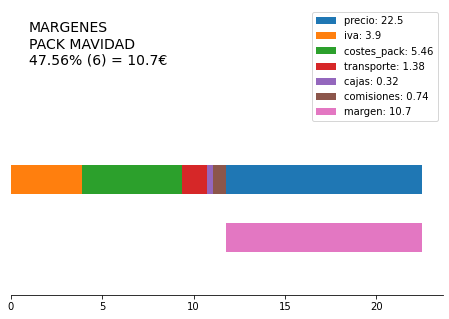

In [248]:
#PACK + HIDRATADA
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=22.5
width=0.1
#precio
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO Y MANTECA
costes_pack=costes_pack1+costes_pack2+costes_pack3
left=iva
p3 = ax.barh([1],[costes_pack],width,left=left,label='costes_pack: {}'.format(costes_pack))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+costes_pack
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#margen
left=left+comisiones
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nPACK MAVIDAD\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

In [249]:
total=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10].sum()
print(total)
sales_dist=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10]/total
sales_dist

635


0_cre||0_bal||0_mant||1_packH||0_packC    0.474016
0_cre||0_bal||0_mant||0_packH||0_packC    0.190551
0_cre||0_bal||1_mant||0_packH||0_packC    0.081890
0_cre||0_bal||0_mant||3_packH||0_packC    0.066142
0_cre||0_bal||0_mant||2_packH||0_packC    0.061417
0_cre||0_bal||2_mant||0_packH||0_packC    0.036220
0_cre||0_bal||1_mant||2_packH||0_packC    0.028346
0_cre||0_bal||3_mant||0_packH||0_packC    0.023622
0_cre||0_bal||1_mant||1_packH||0_packC    0.020472
0_cre||0_bal||6_mant||0_packH||0_packC    0.017323
dtype: float64

MANTECA: 45.4%
CREMA: 28.5%
BALSAMO: 32.5%
PACK: 39.1%

In [134]:
labels = ['1pack','1manteca','3packs','2packs','2mantecas','1mateca_2packs','1mateca_1packs',
         '3matecas','5matecas','4packs']

marg = [0.391,0.454,0.391,0.391,0.454,0.412,0.4225,0.454,0.454,0.391] 

mantecas = [0,1,0,0,2,1,1,3,5,0]
packs = [1,0,3,2,0,2,1,0,0,4]

margenes = pd.DataFrame({'ventas mas comunes':labels,
                         'mantecas':mantecas,
                         'packs':packs,
                         '% recurrencia':sales_dist,
                         'margenes':marg}).reset_index(drop=True)
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes
0,1pack,0,1,0.593684,0.3910
1,1manteca,1,0,0.090526,0.4540
2,3packs,0,3,0.080000,0.3910
3,2packs,0,2,0.069474,0.3910
4,2mantecas,2,0,0.037895,0.4540
5,1mateca_2packs,1,2,0.035789,0.4120
6,1mateca_1packs,1,1,0.027368,0.4225
7,3matecas,3,0,0.025263,0.4540
8,5matecas,5,0,0.021053,0.4540
9,4packs,0,4,0.018947,0.3910


In [135]:
margenes['precio']=margenes['mantecas']*10+margenes['packs']*18

In [136]:
(margenes['margenes']*margenes['% recurrencia']).sum()/margenes['% recurrencia'].sum()

0.40362210526315795

# OBJETIVO DE VENTAS

In [137]:
# COSTES FIJOS EN NIKKI 600€
600/0.40362210526315795

1486.5389981770336

In [250]:
1486*12

17832

In [138]:
margenes['ventas']=margenes['% recurrencia']*1500

In [139]:
margenes['beneficios']=margenes['ventas']*margenes['margenes']

In [140]:
margenes['packs_total'] = margenes['packs']*margenes['ventas']/(margenes['precio'])

In [141]:
margenes['mantecas_total'] =margenes['mantecas']*margenes['ventas']/(margenes['precio'])

In [142]:
margenes=margenes.replace(np.nan,0)

In [143]:
margenes['mantecas_total'] = margenes['mantecas_total']
margenes['packs_total'] = margenes['packs_total']

In [144]:
margenes['% recurrencia']=margenes['% recurrencia'].apply(lambda x:str(round(100*x,2))+'%')

In [145]:
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes,precio,ventas,beneficios,packs_total,mantecas_total
0,1pack,0,1,59.37%,0.3910,18,890.526316,348.195789,49.473684,0.000000
1,1manteca,1,0,9.05%,0.4540,10,135.789474,61.648421,0.000000,13.578947
2,3packs,0,3,8.0%,0.3910,54,120.000000,46.920000,6.666667,0.000000
3,2packs,0,2,6.95%,0.3910,36,104.210526,40.746316,5.789474,0.000000
4,2mantecas,2,0,3.79%,0.4540,20,56.842105,25.806316,0.000000,5.684211
5,1mateca_2packs,1,2,3.58%,0.4120,46,53.684211,22.117895,2.334096,1.167048
6,1mateca_1packs,1,1,2.74%,0.4225,28,41.052632,17.344737,1.466165,1.466165
7,3matecas,3,0,2.53%,0.4540,30,37.894737,17.204211,0.000000,3.789474
8,5matecas,5,0,2.11%,0.4540,50,31.578947,14.336842,0.000000,3.157895
9,4packs,0,4,1.89%,0.3910,72,28.421053,11.112632,1.578947,0.000000


## 18€ packs y 10€ mantecas

In [146]:
print('Estadisticas mensuales')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()

Estadisticas mensuales


mantecas_total      28.843740
packs_total         67.309033
ventas            1500.000000
beneficios         605.433158
dtype: float64

In [147]:
print('Estadisticas diarias')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()/30

Estadisticas diarias


mantecas_total     0.961458
packs_total        2.243634
ventas            50.000000
beneficios        20.181105
dtype: float64